In [1]:
import torch
from super_gradients.training import models
from super_gradients.training import Trainer, models
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val,
)
import super_gradients.training
super_gradients.setup_device(device='cuda')
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics,
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

DEVICE = 'cuda:0'
BATCH_SIZE = 1
WORKERS = 8
#model = torch.load('/home/matthias/workspace/Coding/00_vista_medizina/bone_frac_obj_det/yoloNAS/checkpoints/yolo_nas_s/RUN_20241117_212610_007684/ckpt_epoch_100.pth', map_location=torch.device(DEVICE))

[2024-11-22 14:40:44] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/matthias/sg_logs/console.log


2024-11-22 14:40:49.071376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732275649.110774   14635 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732275649.122226   14635 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 14:40:49.162984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[WARNING]No module named 'pycocotools'


In [2]:
ROOT_DIR = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch'
train_imgs_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/train/images'
train_labels_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/train/labels'
val_imgs_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/valid/images'
val_labels_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/valid/labels'
test_imgs_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images'
test_labels_dir = '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/labels'
classes = ['forearm_fracture']

In [3]:
dataset_params = {
    'data_dir': ROOT_DIR,
    'train_images_dir': train_imgs_dir,
    'train_labels_dir': train_labels_dir,
    'val_images_dir': val_imgs_dir,
    'val_labels_dir': val_labels_dir,
    'test_images_dir': test_imgs_dir,
    'test_labels_dir': test_labels_dir,
    'classes': classes,
    'ignore_empty_annotations': True,
}

In [4]:
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes'],
        'ignore_empty_annotations': dataset_params['ignore_empty_annotations'],
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS,
    }
)

[2024-11-22 14:40:55] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [5]:
dict_model_paths = {
    #'f1@0.5opt': "/home/matthias/workspace/Coding/00_vista_medizina/10_weights/yoloNAS/checkpoints/yolo_nas_s/f1_0p5_opt/ckpt_best.pth",
    #'recall@0.5opt': "/home/matthias/workspace/Coding/00_vista_medizina/10_weights/yoloNAS/checkpoints/yolo_nas_s/recall_0p5_opt/ckpt_best.pth",
    'mAP50:95@0.5opt': "/home/matthias/workspace/Coding/00_vista_medizina/10_weights/yoloNAS/pretrained_weights/yoloNAS_s_own_forearm/ckpt_best.pth",
}

In [6]:
dict_models_loaded = {}
for model_name in list(dict_model_paths.keys()):
    print("Model: ", model_name)
    dict_models_loaded.update({model_name: 
                        models.get('yolo_nas_s',
                        num_classes=80,
                        checkpoint_path=dict_model_paths[model_name])})
print("Models: ", dict_models_loaded.keys())

Indexing dataset annotations: 100%|██████████| 30/30 [00:00<00:00, 3004.73it/s]


Model:  mAP50:95@0.5opt


/home/matthias/anaconda3/envs/cv_yoloNAS/lib/python3.10/site-packages/super_gradients/training/utils/checkpoint_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [7]:
#best_model_1 = models.get('yolo_nas_s',
#                        num_classes=80,
#                        checkpoint_path="/home/matthias/workspace/Coding/00_vista_medizina/10_weights/yoloNAS/checkpoints/yolo_nas_s/RUN_20241119_145001_263683/ckpt_best.pth")

In [8]:
trainer = Trainer(
        experiment_name='yolo_nas_s',
    )

In [ ]:
dict_trainers = {}

for model_name in list(dict_models_loaded.keys()):
    print("Model: ", model_name)
    """print(trainer.test(model=dict_models_loaded[model_name],
                test_loader=test_data,
                test_metrics_list=DetectionMetrics_050(score_thres=0.5,
                                                    top_k_predictions=300,
                                                    num_cls=len(dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                            nms_top_k=1000,
                                                                                                            max_predictions=300,
                                                                                                            nms_threshold=0.1) #0.7
                                                    )))"""
    dict_trainers[model_name] = trainer.test(model=dict_models_loaded[model_name],
                test_loader=test_data,
                test_metrics_list=DetectionMetrics(score_thres=0.0,
                                                    top_k_predictions=300,
                                                    num_cls=len(dataset_params['classes']),
                                                    normalize_targets=True,
                                                    iou_thres=0.1,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.0,
                                                                                                            nms_top_k=1000,
                                                                                                            max_predictions=300,
                                                                                                            nms_threshold=0.1) #0.7
                                                    ))
    print(dict_trainers[model_name])

Model:  mAP50:95@0.5opt


Testing:  97%|█████████▋| 29/30 [00:02<00:00, 15.01it/s]

Testing: 100%|██████████| 30/30 [00:03<00:00,  9.65it/s]


{'Precision@0.10': 0.03433923050761223, 'Recall@0.10': 1.0, 'mAP@0.10': 0.8329266309738159, 'F1@0.10': 0.06639839708805084, 'Best_score_threshold': 0.25999999046325684}


In [10]:
import os
os.getcwd()

'/home/matthias/workspace/Coding/00_vista_medizina/vista_bone_frac/yoloNAS'

In [11]:
list_paths_files = []
for dirpath, _, filenames in os.walk(dataset_params['test_images_dir']):
    
    for filename in filenames:

        if filename.endswith('.' + 'jpg'):
            list_paths_files.append(os.path.join(dirpath, filename))

In [12]:
list_paths_files

['/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images/image1_952_png_jpg.rf.7cd7e9fe22da3cf5f149530e10dd7ccb.jpg',
 '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images/image2_1606_png_jpg.rf.b3c1cb3b771906d15f7f4e4aa911ad11.jpg',
 '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images/image1_848_png_jpg.rf.6a4b3d9be6b78d4f91ba17089c12918a.jpg',
 '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images/image1_796_png_jpg.rf.d4a059956064afab62f95c1cc80b2ab8.jpg',
 '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytorch/test/images/image2_1232_png_jpg.rf.61cf8895d12badc99233fe64a9138161.jpg',
 '/home/matthias/workspace/Coding/00_vista_medizina/00_data/2024-11-17/forearm_w_aug/fa.v6i.yolov7pytor

Testing: 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


/home/matthias/anaconda3/envs/cv_yoloNAS/lib/python3.10/site-packages/super_gradients/training/pipelines/pipelines.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast(enabled=self.fp16):
[2024-11-22 14:41:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


{'Precision@0.10': 0.03433923050761223, 'Recall@0.10': 1.0, 'mAP@0.10': 0.8329266309738159, 'F1@0.10': 0.06639839708805084, 'Best_score_threshold': 0.25999999046325684}



++++++++++++++++++++++++
+++++++++++++++++++++
Model: mAP50:95@0.5opt
Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


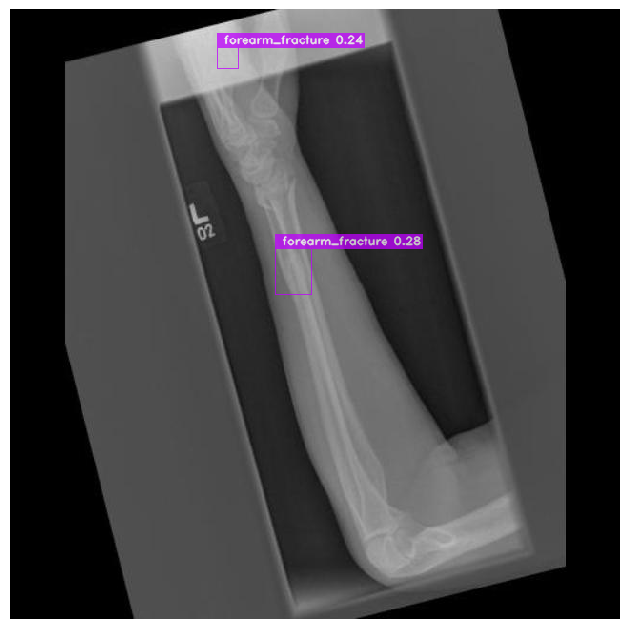

[2024-11-22 14:41:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


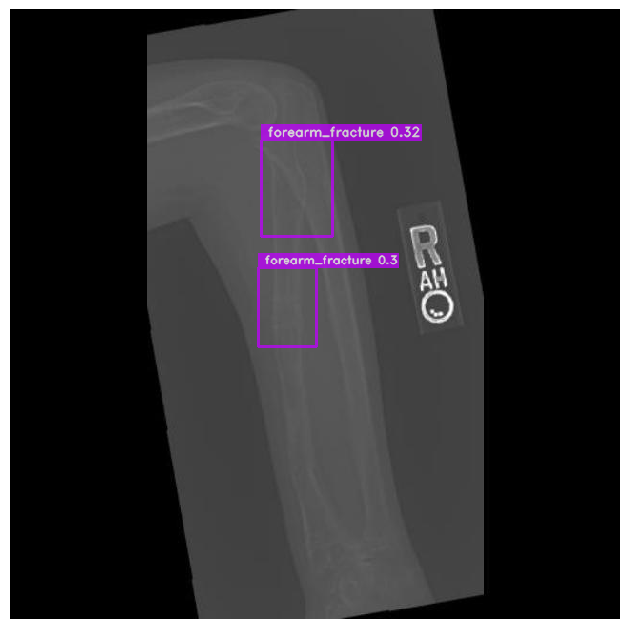

[2024-11-22 14:41:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


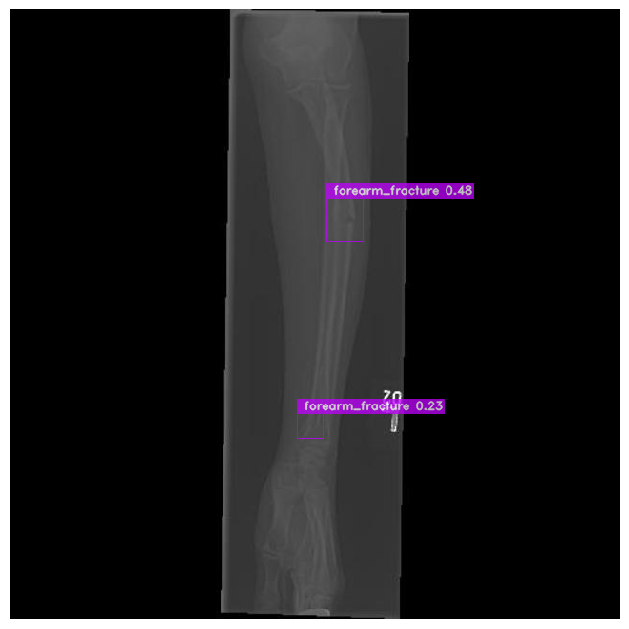

[2024-11-22 14:41:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


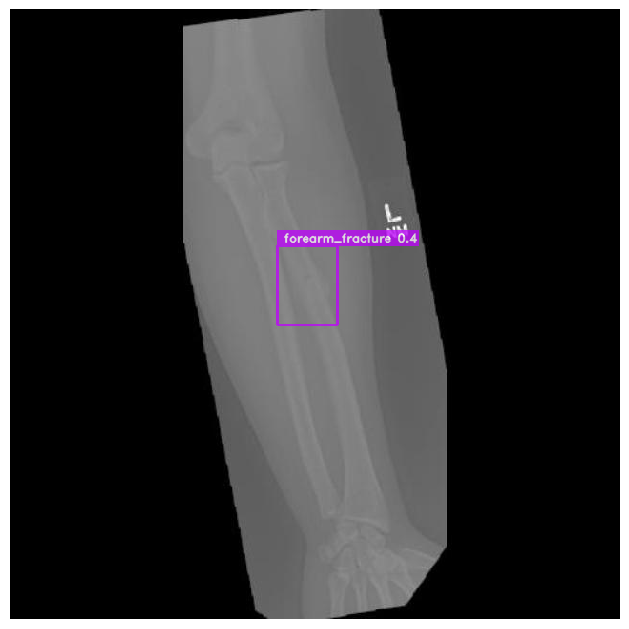

[2024-11-22 14:41:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


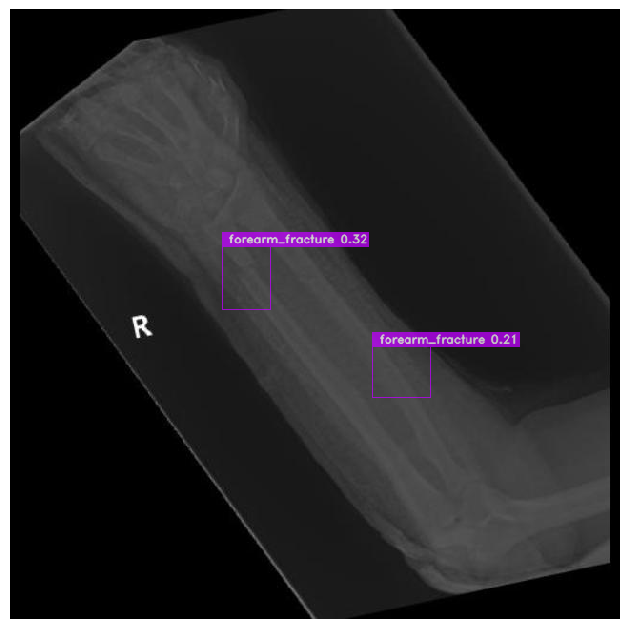

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


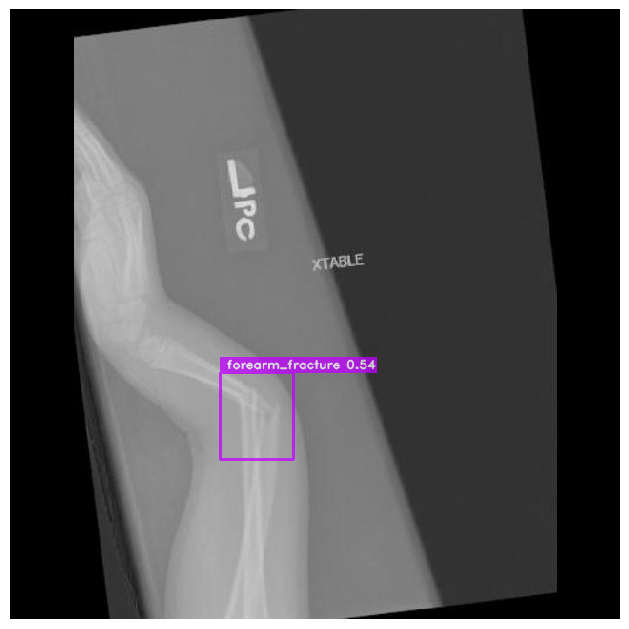

[2024-11-22 14:41:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


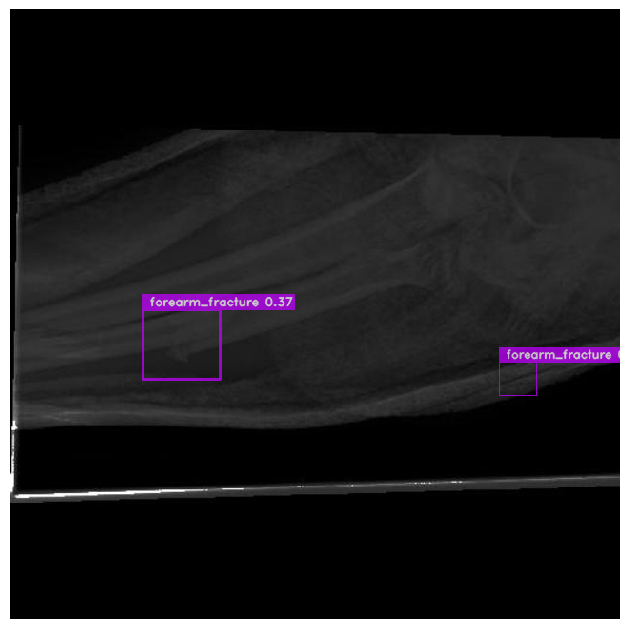

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


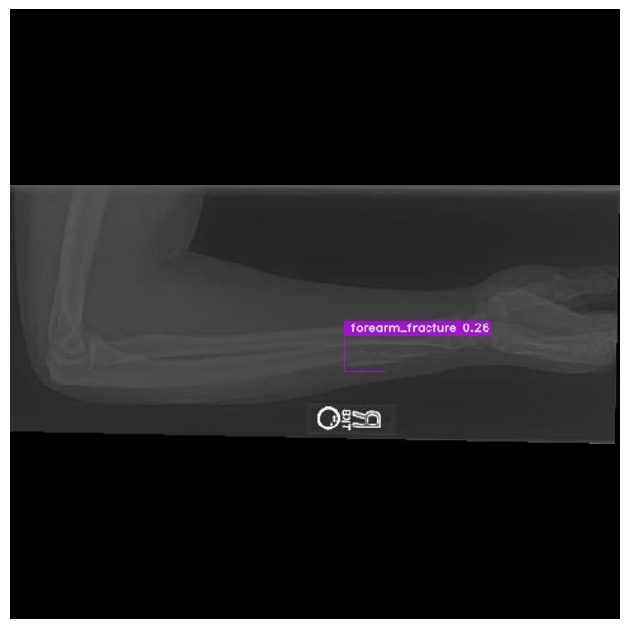

[2024-11-22 14:41:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


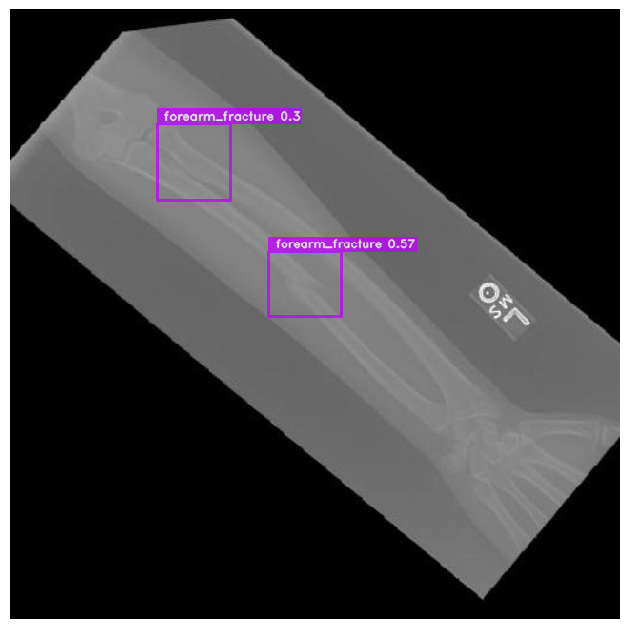

[2024-11-22 14:41:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


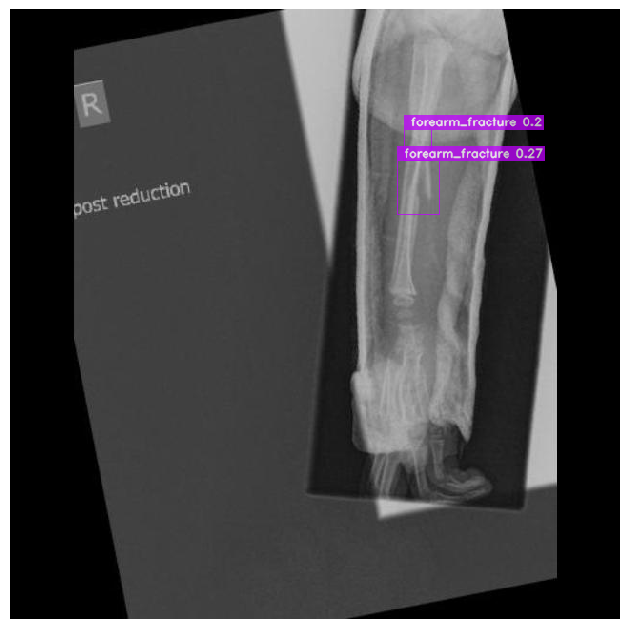

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


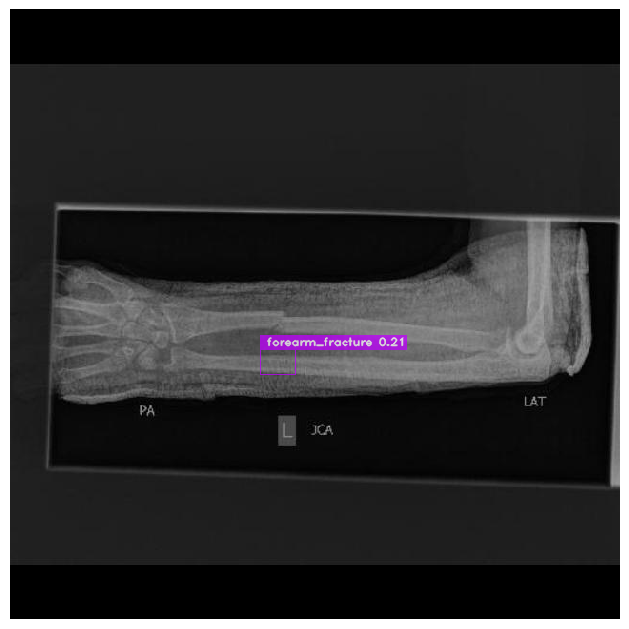

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


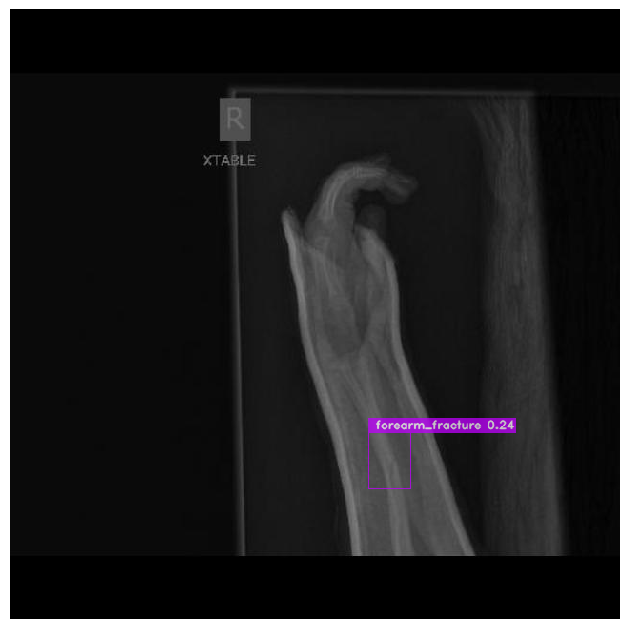

[2024-11-22 14:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


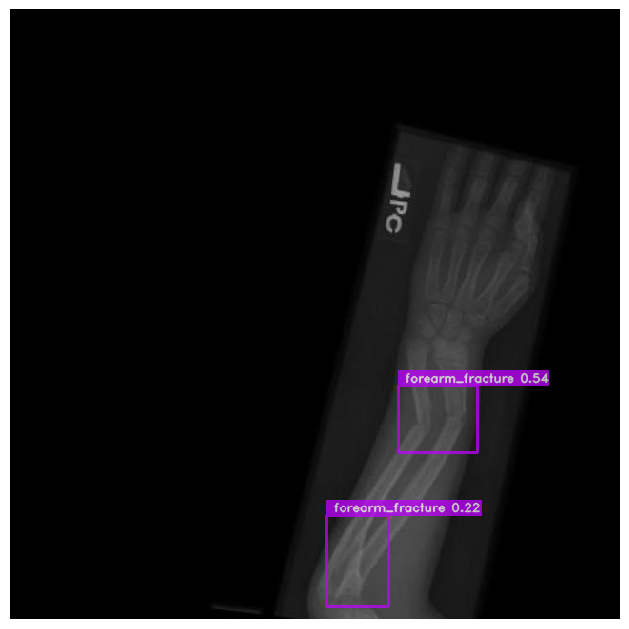

[2024-11-22 14:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


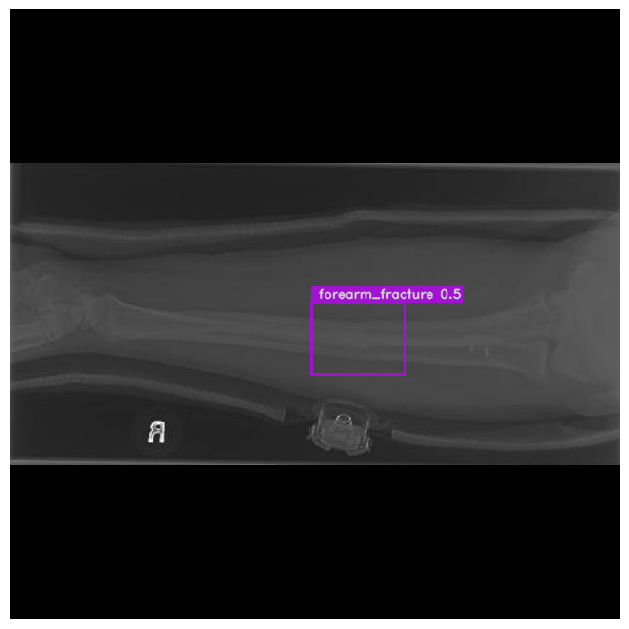

[2024-11-22 14:41:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


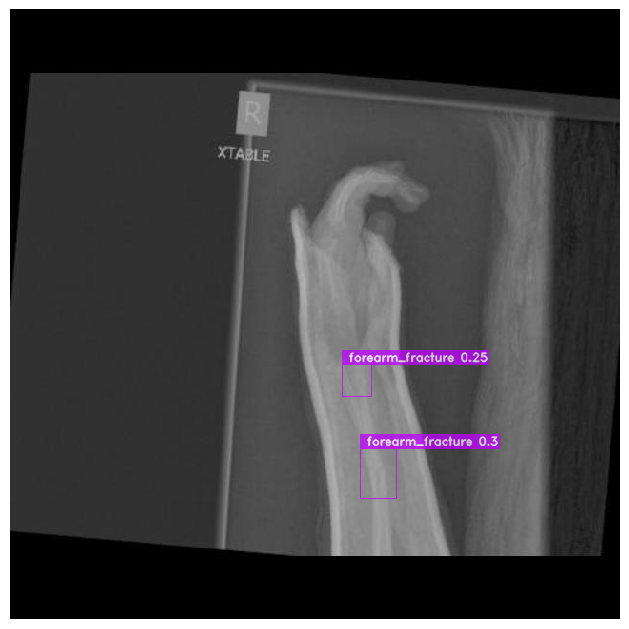

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


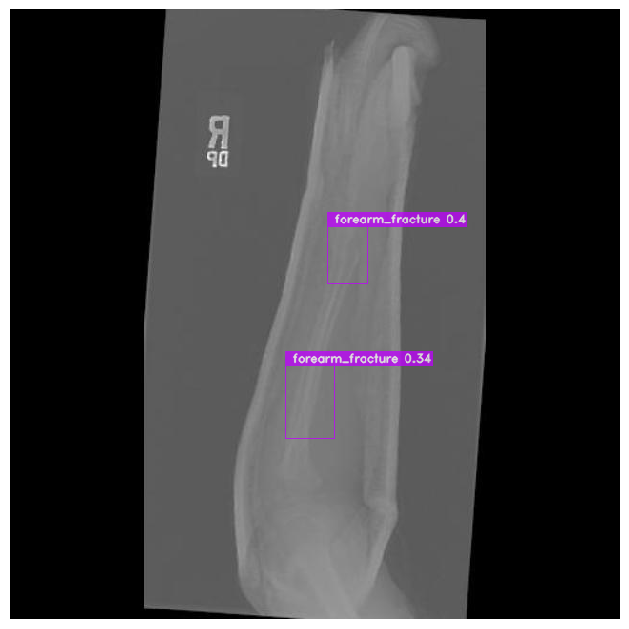

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


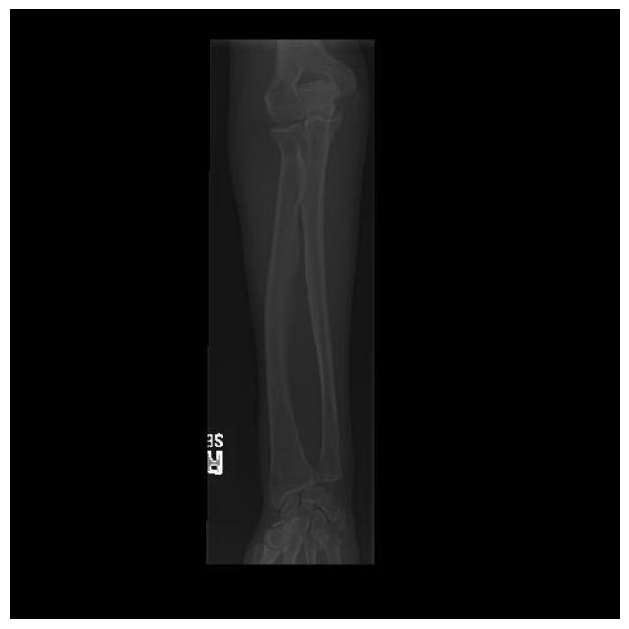

[2024-11-22 14:41:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


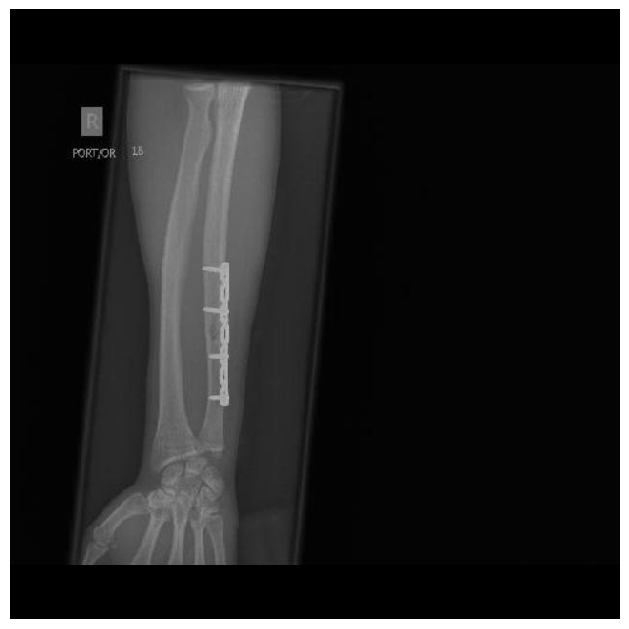

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


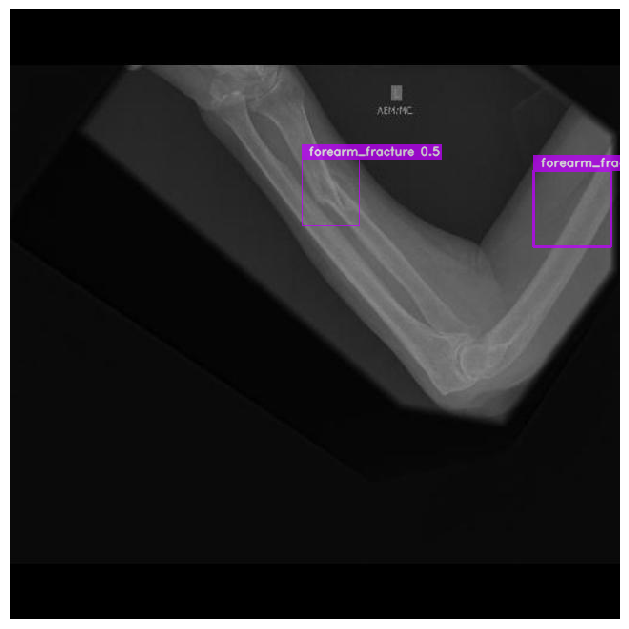

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


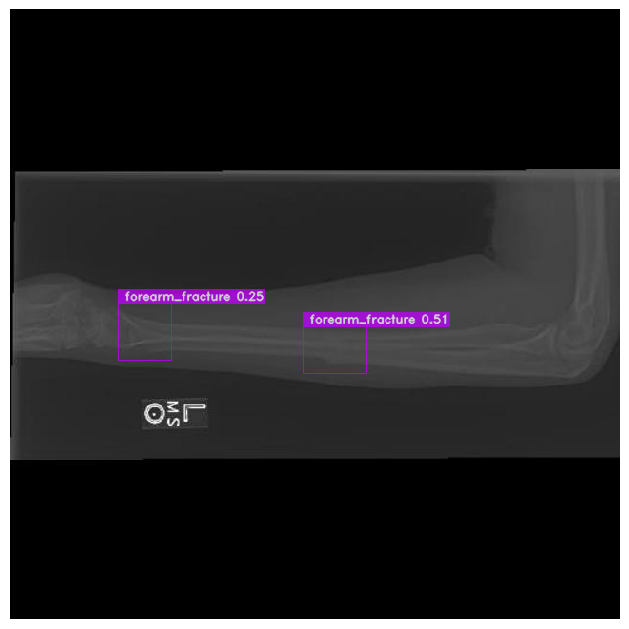

[2024-11-22 14:41:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


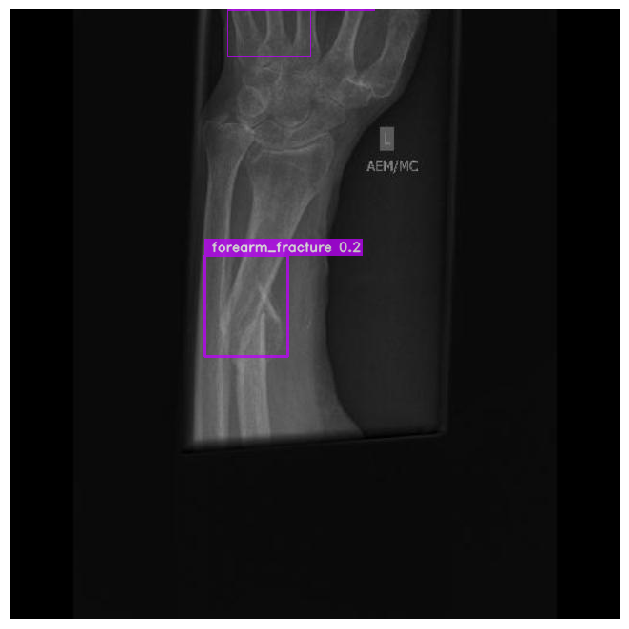

[2024-11-22 14:41:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


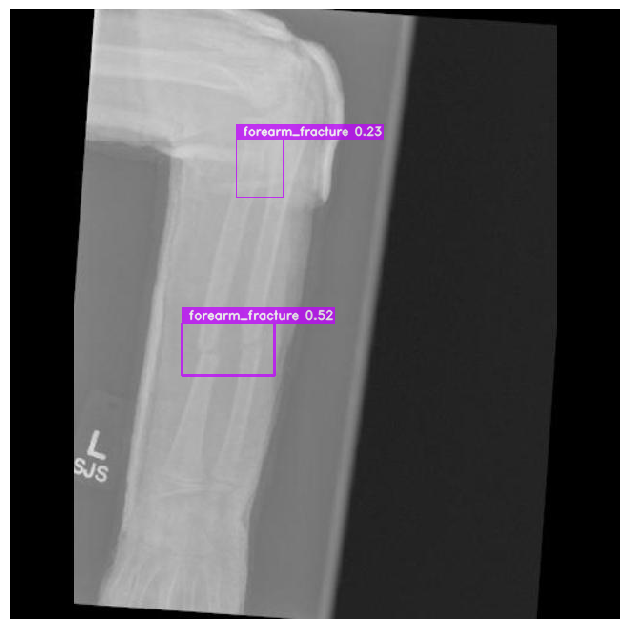

[2024-11-22 14:41:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


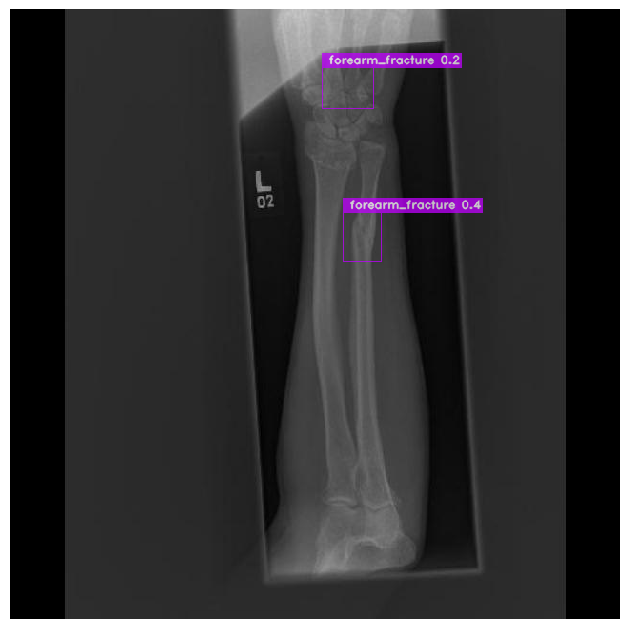

[2024-11-22 14:41:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


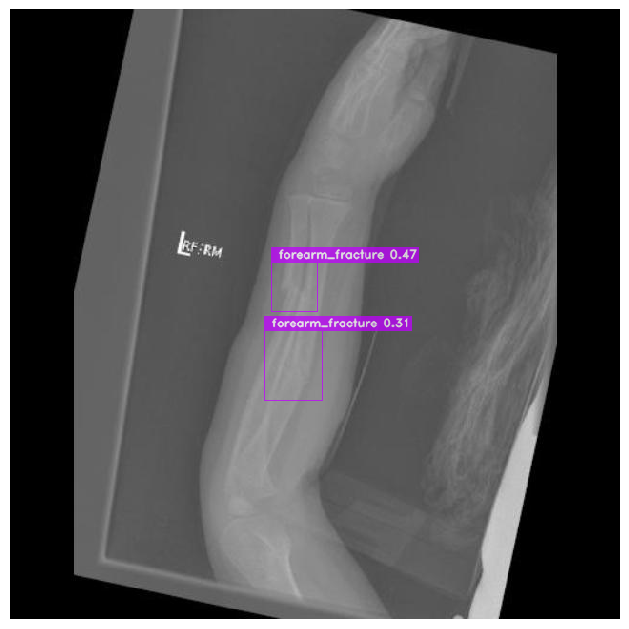

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


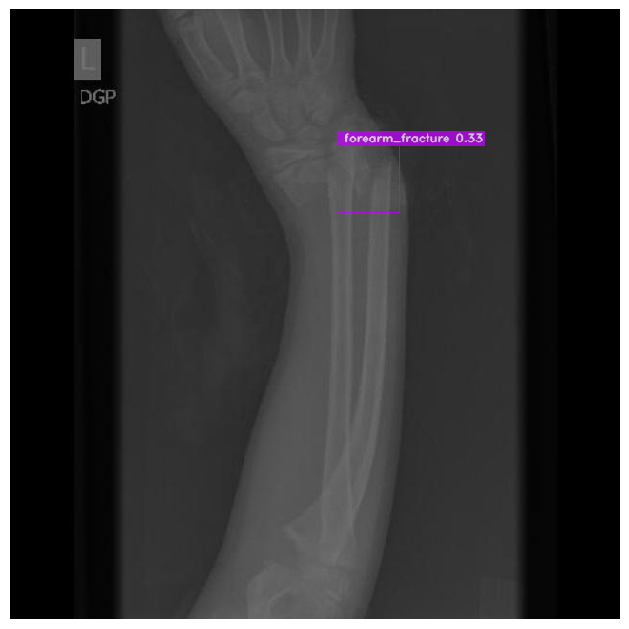

[2024-11-22 14:41:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


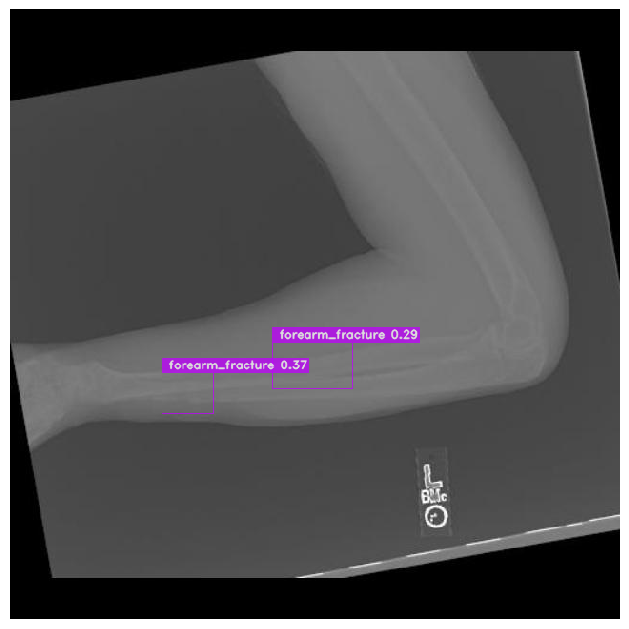

[2024-11-22 14:41:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


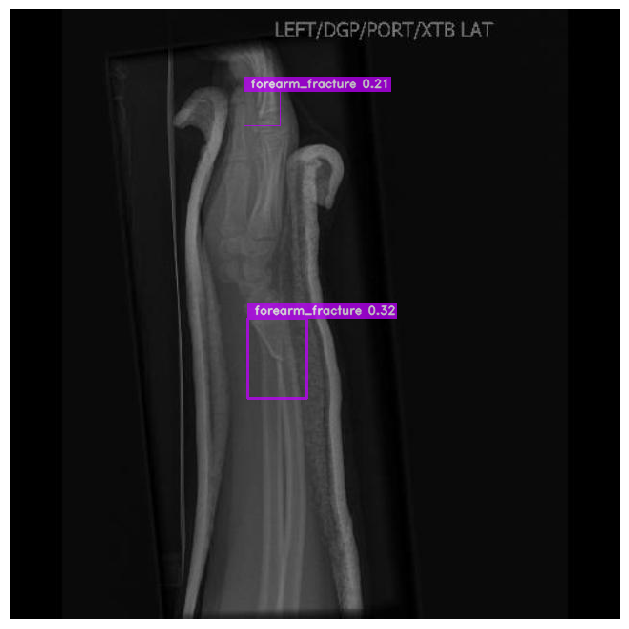

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


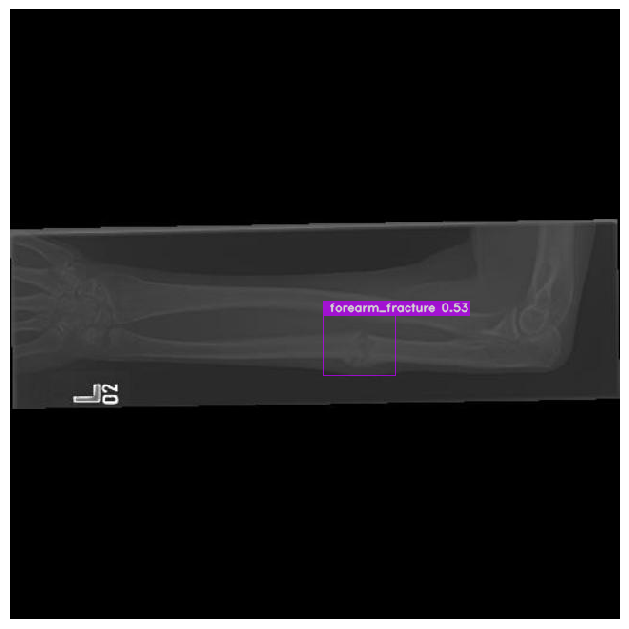

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


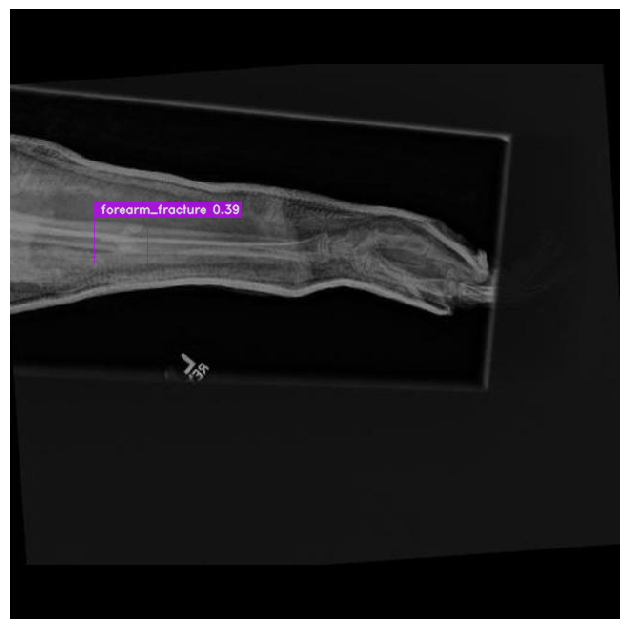

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


[2024-11-22 14:41:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


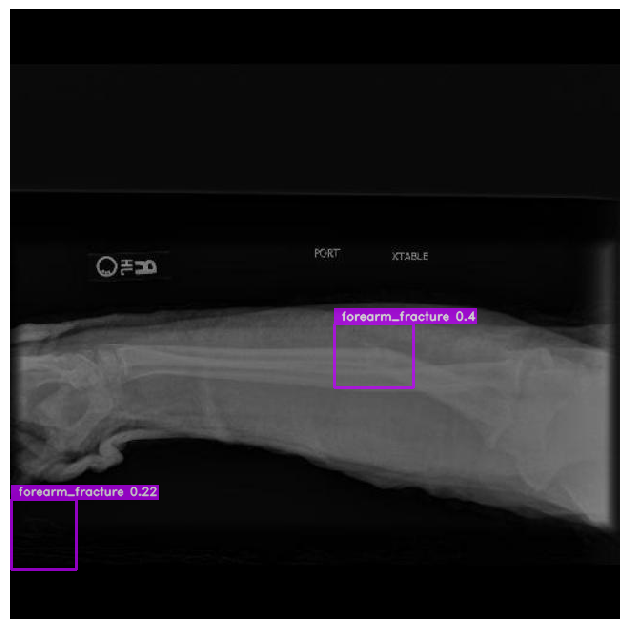

'\n    def predict(\n        self,\n        images: ImageSource,\n        iou: Optional[float] = None,\n        conf: Optional[float] = None,\n        batch_size: int = 32,\n        fuse_model: bool = True,\n        skip_image_resizing: bool = False,\n        nms_top_k: Optional[int] = None,\n        max_predictions: Optional[int] = None,\n        multi_label_per_box: Optional[bool] = None,\n        class_agnostic_nms: Optional[bool] = None,\n        fp16: bool = True,\n    ) -> ImagesDetectionPrediction:\n        Predict an image or a list of images.\n\n        :param images:              Images to predict.\n        :param iou:                 (Optional) IoU threshold for the nms algorithm. If None, the default value associated to the training is used.\n        :param conf:                (Optional) Below the confidence threshold, prediction are discarded.\n                                    If None, the default value associated to the training is used.\n        :param batch_size:   

Type: <class 'super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction'>


In [13]:
model = list(dict_models_loaded.keys())[0]
print("\n++++++++++++++++++++++++\n+++++++++++++++++++++\nModel: " + model)
for path_image in list_paths_files:
    prediction = dict_models_loaded[model].predict(
        images=path_image,
        iou=0.0,
        conf=0.2,
        max_predictions=2,
    )
    #prediction = dict_models_loaded[model](path_image)
    print('Type: %s' % type(prediction))
    #print('Shape: %s' % prediction.shape)
    prediction.show()

"""
    def predict(
        self,
        images: ImageSource,
        iou: Optional[float] = None,
        conf: Optional[float] = None,
        batch_size: int = 32,
        fuse_model: bool = True,
        skip_image_resizing: bool = False,
        nms_top_k: Optional[int] = None,
        max_predictions: Optional[int] = None,
        multi_label_per_box: Optional[bool] = None,
        class_agnostic_nms: Optional[bool] = None,
        fp16: bool = True,
    ) -> ImagesDetectionPrediction:
        Predict an image or a list of images.

        :param images:              Images to predict.
        :param iou:                 (Optional) IoU threshold for the nms algorithm. If None, the default value associated to the training is used.
        :param conf:                (Optional) Below the confidence threshold, prediction are discarded.
                                    If None, the default value associated to the training is used.
        :param batch_size:          Maximum number of images to process at the same time.
        :param fuse_model:          If True, create a copy of the model, and fuse some of its layers to increase performance. This increases memory usage.
        :param skip_image_resizing: If True, the image processor will not resize the images.
        :param nms_top_k:           (Optional) The maximum number of detections to consider for NMS.
        :param max_predictions:     (Optional) The maximum number of detections to return.
        :param multi_label_per_box: (Optional) If True, each anchor can produce multiple labels of different classes.
                                    If False, each anchor can produce only one label of the class with the highest score.
        :param class_agnostic_nms:  (Optional) If True, perform class-agnostic NMS (i.e IoU of boxes of different classes is checked).
                                    If False NMS is performed separately for each class.
        :param fp16:                        If True, use mixed precision for inference.
"""

In [14]:
model = list(dict_models_loaded.keys())[1]
print("\n++++++++++++++++++++++++\n+++++++++++++++++++++\nModel: " + model)
for path_image in list_paths_files:
    prediction = dict_models_loaded[model].predict(
        images=path_image,
        iou=0.0,
        conf=0.2,
        max_predictions=2,
    )
    #prediction = dict_models_loaded[model](path_image)
    print('Type: %s' % type(prediction))
    #print('Shape: %s' % prediction.shape)
    prediction.show()

"""
    def predict(
        self,
        images: ImageSource,
        iou: Optional[float] = None,
        conf: Optional[float] = None,
        batch_size: int = 32,
        fuse_model: bool = True,
        skip_image_resizing: bool = False,
        nms_top_k: Optional[int] = None,
        max_predictions: Optional[int] = None,
        multi_label_per_box: Optional[bool] = None,
        class_agnostic_nms: Optional[bool] = None,
        fp16: bool = True,
    ) -> ImagesDetectionPrediction:
        Predict an image or a list of images.

        :param images:              Images to predict.
        :param iou:                 (Optional) IoU threshold for the nms algorithm. If None, the default value associated to the training is used.
        :param conf:                (Optional) Below the confidence threshold, prediction are discarded.
                                    If None, the default value associated to the training is used.
        :param batch_size:          Maximum number of images to process at the same time.
        :param fuse_model:          If True, create a copy of the model, and fuse some of its layers to increase performance. This increases memory usage.
        :param skip_image_resizing: If True, the image processor will not resize the images.
        :param nms_top_k:           (Optional) The maximum number of detections to consider for NMS.
        :param max_predictions:     (Optional) The maximum number of detections to return.
        :param multi_label_per_box: (Optional) If True, each anchor can produce multiple labels of different classes.
                                    If False, each anchor can produce only one label of the class with the highest score.
        :param class_agnostic_nms:  (Optional) If True, perform class-agnostic NMS (i.e IoU of boxes of different classes is checked).
                                    If False NMS is performed separately for each class.
        :param fp16:                        If True, use mixed precision for inference.
"""

IndexError: list index out of range

In [ ]:
model = list(dict_models_loaded.keys())[2]
print("\n++++++++++++++++++++++++\n+++++++++++++++++++++\nModel: " + model)
for path_image in list_paths_files:
    print('Type: %s' % type(prediction))
    prediction = dict_models_loaded[model].predict(
        images=path_image,
        iou=0.0,
        conf=0.2,
        max_predictions=2,
    )
    #prediction = dict_models_loaded[model](path_image)
    #print('Shape: %s' % prediction.shape)
    prediction.show()

"""
    def predict(
        self,
        images: ImageSource,
        iou: Optional[float] = None,
        conf: Optional[float] = None,
        batch_size: int = 32,
        fuse_model: bool = True,
        skip_image_resizing: bool = False,
        nms_top_k: Optional[int] = None,
        max_predictions: Optional[int] = None,
        multi_label_per_box: Optional[bool] = None,
        class_agnostic_nms: Optional[bool] = None,
        fp16: bool = True,
    ) -> ImagesDetectionPrediction:
        Predict an image or a list of images.

        :param images:              Images to predict.
        :param iou:                 (Optional) IoU threshold for the nms algorithm. If None, the default value associated to the training is used.
        :param conf:                (Optional) Below the confidence threshold, prediction are discarded.
                                    If None, the default value associated to the training is used.
        :param batch_size:          Maximum number of images to process at the same time.
        :param fuse_model:          If True, create a copy of the model, and fuse some of its layers to increase performance. This increases memory usage.
        :param skip_image_resizing: If True, the image processor will not resize the images.
        :param nms_top_k:           (Optional) The maximum number of detections to consider for NMS.
        :param max_predictions:     (Optional) The maximum number of detections to return.
        :param multi_label_per_box: (Optional) If True, each anchor can produce multiple labels of different classes.
                                    If False, each anchor can produce only one label of the class with the highest score.
        :param class_agnostic_nms:  (Optional) If True, perform class-agnostic NMS (i.e IoU of boxes of different classes is checked).
                                    If False NMS is performed separately for each class.
        :param fp16:                        If True, use mixed precision for inference.
"""